In [1]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from Signal_Analyzer import  *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
class CIN(nn.Module):
    def __init__(self, num_features, num_latent_variables):
        super(CIN, self).__init__()
        self.num_features = num_features
        self.inst_norm = nn.InstanceNorm1d(num_features, affine=False)
        self.conv_alpha = nn.Conv1d(in_channels=num_latent_variables, out_channels=num_features, kernel_size=1)
        self.conv_beta = nn.Conv1d(in_channels=num_latent_variables, out_channels=num_features, kernel_size=1)

    def forward(self, x, z):
        out = self.inst_norm(x)
        
        alpha = self.conv_alpha(z)
        beta = self.conv_beta(z)
        
        alpha = alpha.expand_as(out)
        beta = beta.expand_as(out)

        return alpha * out + beta

In [3]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_latent_variables, no_norm=False):
        super(ResBlock, self).__init__()
        self.no_norm = no_norm

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.process1 = CIN(in_channels, num_latent_variables) if not no_norm else nn.Identity()
        self.process2 = CIN(out_channels, num_latent_variables) if not no_norm else nn.Identity()

    def forward(self, x, z):
        processed1 = self.process1(x, z) if not self.no_norm else x
        conv1_out = self.conv1(processed1)
        conv1_activated = self.leaky_relu(processed1)

        processed2 = self.process2(conv1_activated, z) if not self.no_norm else conv1_activated
        conv2_out = self.conv2(processed2)
        conv2_activated = self.leaky_relu(conv2_out)

        conv3_out = self.conv3(conv2_activated)

        return conv3_out + conv1_out


In [4]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, num_latent_variables):
        super(Down, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.res_block = ResBlock(in_channels=out_channels, out_channels=out_channels, num_latent_variables=num_latent_variables, no_norm=False)

    def forward(self, x, condition):
        x = self.conv(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = self.res_block(x, condition)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, num_latent_variables):
        super(Up, self).__init__()
        self.conv = nn.Conv1d(in_channels + skip_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.res_block = ResBlock(out_channels, out_channels, num_latent_variables)

    def forward(self, x, skip_input, z, upsample=True):
        if skip_input is not None:
            x = torch.cat((x, skip_input), dim=1)
        
        x = self.conv(x)
        x = self.relu(x)
        
        if upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        
        x = self.res_block(x, z)

        return x

In [5]:
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, base_channels, num_latent_variables):
        super(UNetGenerator, self).__init__()
        
        # Initial convolution block
        self.init_conv = nn.Conv1d(in_channels, base_channels, kernel_size=3, stride=1, padding=1)
        self.init_relu = nn.LeakyReLU(0.2, inplace=True)
        
        # ResBlock without normalization
        self.res_block_no_norm = ResBlock(base_channels, base_channels, num_latent_variables, no_norm=True)
        
        # Down-sampling
        self.down1 = Down(base_channels, base_channels * 2, num_latent_variables)
        self.down2 = Down(base_channels * 2, base_channels * 4, num_latent_variables)
        self.down3 = Down(base_channels * 4, base_channels * 8, num_latent_variables)
        
        # Middle ResBlock
        self.middle_res_block = ResBlock(base_channels * 8, base_channels * 8, num_latent_variables)
        
        # Up-sampling without skip connections (first up-sampling step)
        self.up1 = Up(base_channels * 8, 0, base_channels * 4, num_latent_variables)
        self.up2 = Up(base_channels * 4, base_channels * 4, base_channels * 2, num_latent_variables)
        self.up3 = Up(base_channels * 2, base_channels * 2, base_channels, num_latent_variables)
        self.up4 = Up(base_channels, base_channels, base_channels, num_latent_variables) 
        
        # Final convolution and Tanh
        self.final_conv = nn.Conv1d(base_channels, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()
    
    def forward(self, x, z):
        # Initial conv and relu
        x = self.init_conv(x)
        x = self.init_relu(x)
        
        # ResBlock without norm
        x = self.res_block_no_norm(x, z)
        
        # Down-sampling
        d1 = self.down1(x, z)
        d2 = self.down2(d1, z)
        d3 = self.down3(d2, z)
        
        # Middle ResBlock
        m = self.middle_res_block(d3, z)
        
        # Up-sampling without skip connection
        u1 = self.up1(m, None, z)
        
        # Up-sampling with skip connections
        u2 = self.up2(u1, d2, z)
        u3 = self.up3(u2, d1, z)
        u4 = self.up4(u3, x, z, upsample=False)
        
        # Final convolution and Tanh
        out = self.final_conv(u4)
        out = self.tanh(out)
        
        return out

In [6]:
t = np.linspace(0, 1, 1000)

num_latent_variables = 10

z = torch.randn(1, num_latent_variables, 1)


amplitude_range=(0.5, 1.5)
phase_range=(0, np.pi)
frequency_range=(1, 5)

amplitude = np.random.uniform(*amplitude_range)
phase = np.random.uniform(*phase_range)
frequency = np.random.uniform(*frequency_range) 

input_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)

# Initialize the generator
generator = UNetGenerator(in_channels=1, base_channels=1, num_latent_variables=num_latent_variables)

# Generate the signal with the corrected generator
with torch.no_grad():
    generated_signal = generator(input_signal_tensor, z).squeeze().numpy()

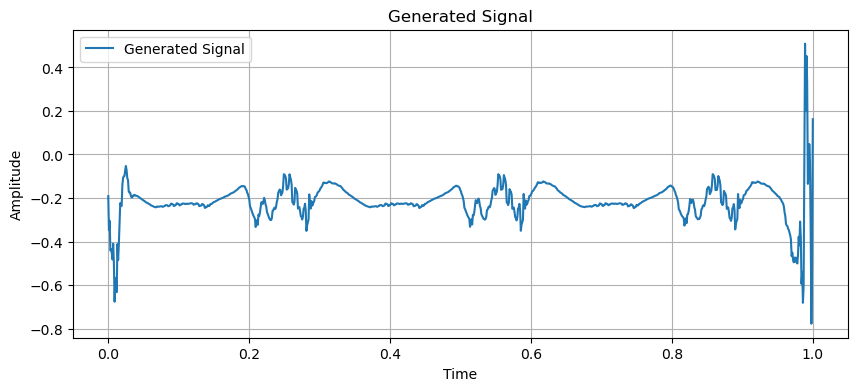

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(t, generated_signal, label='Generated Signal')
plt.title('Generated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

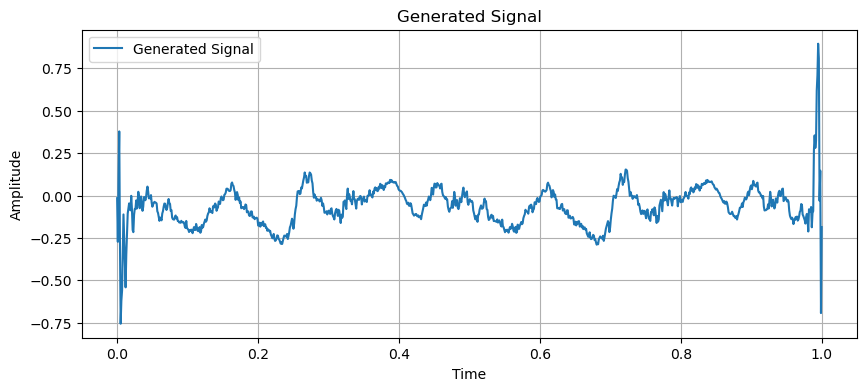

In [28]:
class CIN(nn.Module):
    def __init__(self, num_features, num_latent_variables):
        super(CIN, self).__init__()
        self.num_features = num_features
        self.inst_norm = nn.InstanceNorm1d(num_features, affine=False)
        self.conv_alpha = nn.Conv1d(in_channels=num_latent_variables, out_channels=num_features, kernel_size=1)
        self.conv_beta = nn.Conv1d(in_channels=num_latent_variables, out_channels=num_features, kernel_size=1)

    def forward(self, x, z):
        out = self.inst_norm(x)
        
        alpha = self.conv_alpha(z)
        beta = self.conv_beta(z)
        
        alpha = alpha.expand_as(out)
        beta = beta.expand_as(out)

        return alpha * out + beta
    
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_latent_variables, no_norm=False):
        super(ResBlock, self).__init__()
        self.no_norm = no_norm

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        self.process1 = CIN(in_channels, num_latent_variables) if not no_norm else nn.Identity()
        self.process2 = CIN(out_channels, num_latent_variables) if not no_norm else nn.Identity()

    def forward(self, x, z):
        processed1 = self.process1(x, z) if not self.no_norm else x
        conv1_out = self.conv1(processed1)
        conv1_activated = self.leaky_relu(processed1)

        processed2 = self.process2(conv1_activated, z) if not self.no_norm else conv1_activated
        conv2_out = self.conv2(processed2)
        conv2_activated = self.leaky_relu(conv2_out)

        conv3_out = self.conv3(conv2_activated)

        return conv3_out + conv1_out
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, num_latent_variables):
        super(Down, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.res_block = ResBlock(in_channels=out_channels, out_channels=out_channels, num_latent_variables=num_latent_variables, no_norm=False)

    def forward(self, x, condition):
        x = self.conv(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = self.res_block(x, condition)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, num_latent_variables):
        super(Up, self).__init__()
        self.conv = nn.Conv1d(in_channels + skip_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.res_block = ResBlock(out_channels, out_channels, num_latent_variables)

    def forward(self, x, skip_input, z, upsample=True):
        if skip_input is not None:
            x = torch.cat((x, skip_input), dim=1)
        
        x = self.conv(x)
        x = self.relu(x)
        
        if upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        
        x = self.res_block(x, z)

        return x
    
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, num_latent_variables, base_channels=64):
        super(UNetGenerator, self).__init__()
        
        # Initial convolution block
        self.init_conv = nn.Conv1d(in_channels, base_channels, kernel_size=3, stride=1, padding=1)
        self.init_relu = nn.LeakyReLU(0.2, inplace=True)
        
        # ResBlock without normalization
        self.res_block_no_norm = ResBlock(base_channels, base_channels, num_latent_variables, no_norm=True)
        
        # Down-sampling
        self.down1 = Down(base_channels, base_channels * 2, num_latent_variables)
        self.down2 = Down(base_channels * 2, base_channels * 4, num_latent_variables)
        self.down3 = Down(base_channels * 4, base_channels * 8, num_latent_variables)
        
        # Middle ResBlock
        self.middle_res_block = ResBlock(base_channels * 8, base_channels * 8, num_latent_variables)
        
        # Up-sampling without skip connections (first up-sampling step)
        self.up1 = Up(base_channels * 8, 0, base_channels * 4, num_latent_variables)
        self.up2 = Up(base_channels * 4, base_channels * 4, base_channels * 2, num_latent_variables)
        self.up3 = Up(base_channels * 2, base_channels * 2, base_channels, num_latent_variables)
        self.up4 = Up(base_channels, base_channels, base_channels, num_latent_variables) 
        
        # Final convolution and Tanh
        self.final_conv = nn.Conv1d(base_channels, 1, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()
    
    def forward(self, x, z):
        # Initial conv and relu
        x = self.init_conv(x)
        x = self.init_relu(x)
        
        # ResBlock without norm
        x = self.res_block_no_norm(x, z)
        
        # Down-sampling
        d1 = self.down1(x, z)
        d2 = self.down2(d1, z)
        d3 = self.down3(d2, z)
        
        # Middle ResBlock
        m = self.middle_res_block(d3, z)
        
        # Up-sampling without skip connection
        u1 = self.up1(m, None, z)
        
        # Up-sampling with skip connections
        u2 = self.up2(u1, d2, z)
        u3 = self.up3(u2, d1, z)
        u4 = self.up4(u3, x, z, upsample=False)
        
        # Final convolution and Tanh
        out = self.final_conv(u4)
        out = self.tanh(out)
        
        return out

    
t = np.linspace(0, 1, 1000)

num_latent_variables = 10

z = torch.randn(1, num_latent_variables, 1)


amplitude_range=(0.5, 1.5)
phase_range=(0, np.pi)
frequency_range=(1, 5)

amplitude = np.random.uniform(*amplitude_range)
phase = np.random.uniform(*phase_range)
frequency = np.random.uniform(*frequency_range) 

input_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0)

# Initialize the generator
generator = UNetGenerator(in_channels=1,  num_latent_variables=num_latent_variables)

# Generate the signal with the corrected generator
with torch.no_grad():
    generated_signal = generator(input_signal_tensor, z).squeeze().numpy()

plt.figure(figsize=(10, 4))
plt.plot(t, generated_signal, label='Generated Signal')
plt.title('Generated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()